In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import acquire as a
import prepare as p

### Acquire

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head(2)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0


In [4]:
df.describe()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


### Prepare

In [6]:
df.groupby('Month_Invoiced').sum().head(2)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,20199990000,100199990000,7170.0,35850.0
2014-02-28,20000052061,99592010100,7438.0,37190.0


In [7]:
date1 = df.Month_Invoiced
date1

0         2014-01-31
1         2014-01-31
2         2014-01-31
3         2014-01-31
4         2014-01-31
             ...    
790453    2017-12-31
790454    2017-12-31
790455    2017-12-31
790456    2017-12-31
790457    2017-12-31
Name: Month_Invoiced, Length: 790458, dtype: object

In [8]:
df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced.apply(lambda x: x[:-3]))

In [9]:
df = df.sort_values('Month_Invoiced')

In [10]:
df = df.set_index('Month_Invoiced')

In [13]:
df.groupby('Month_Invoiced').sum().head(2)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-01,20199990000,100199990000,7170.0,35850.0
2014-02-01,20000052061,99592010100,7438.0,37190.0


In [14]:
# Identify what Invoice_Id represents...
df.shape[0], df.Invoice_Id.nunique()

(790458, 790458)

In [15]:
# Identify what Customer_Id represents...
df.shape[0], df.Customer_Id.nunique()

(790458, 29400)

Invoice_Id represents each individual row so it won't be useful in determining any trend. However, Customer_Id is 29,400 unique IDs in the df of ~800k entries.

In [16]:
# Look at whether there is a relationship between sub type and amount
pd.crosstab(df.Subscription_Type, df.Amount)

Amount,0.0,5.0,10.0,15.0,20.0
Subscription_Type,,,,,
0.0,496410,0,0,0,0
1.0,0,178212,0,0,0
2.0,0,0,70706,0,0
3.0,0,0,0,26474,0
4.0,0,0,0,0,18656


Sub type determines how much a customer pays.

[Text(0.5, 1.0, 'Revenue Over time'),
 Text(0, 0.5, 'Revenue'),
 Text(0.5, 0, '')]

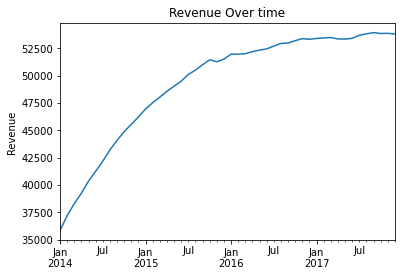

In [17]:
# Take a look at revenue over time on a monthly basis considering
# Amount * Sub Type = Revenue
ax = df.resample('M').Amount.sum().plot()
# ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.set(title='Revenue Over time', ylabel='Revenue', xlabel='')

#### 1.) Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.

In [18]:
# # Define the precentages of train, val, and test
# # Train = 50%
# train_size = int(len(df) * .5)
# # Val = 30%
# validate_size = int(len(df) * .3)
# # Test = the length of the df - train and val
# test_size = int(len(df) - train_size - validate_size)
# # Establish the startin point for test
# validate_end_index = train_size + validate_size

# # split into train, validation, test
# train = df[: train_size]
# validate = df[train_size : validate_end_index]
# test = df[validate_end_index : ]


In [19]:
# Human-Based
df = df.resample('M').sum() # Resample to show monthly trend
train = df.loc[:'2015'] # Train includes everything proir to 2016
validate = df.loc['2016'] # Val is all of 2016
test = df.loc['2017'] # Test is al of 2017

# plt.plot(train.index, train.sales_total)
# plt.plot(test.index, test.sales_total)

In [20]:
# Is len of train + validate + test == length of the entire dataframe? 
len(train) + len(validate) + len(test) == len(df)

True

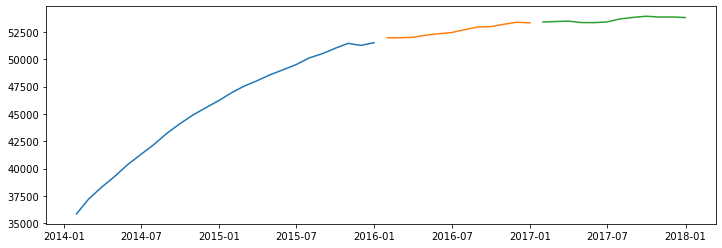

In [21]:
# Plot the df with train, val, and test showing
plt.figure(figsize=(12,4))
plt.plot(train.index, train.Amount)
plt.plot(validate.index, validate.Amount)
plt.plot(test.index, test.Amount)

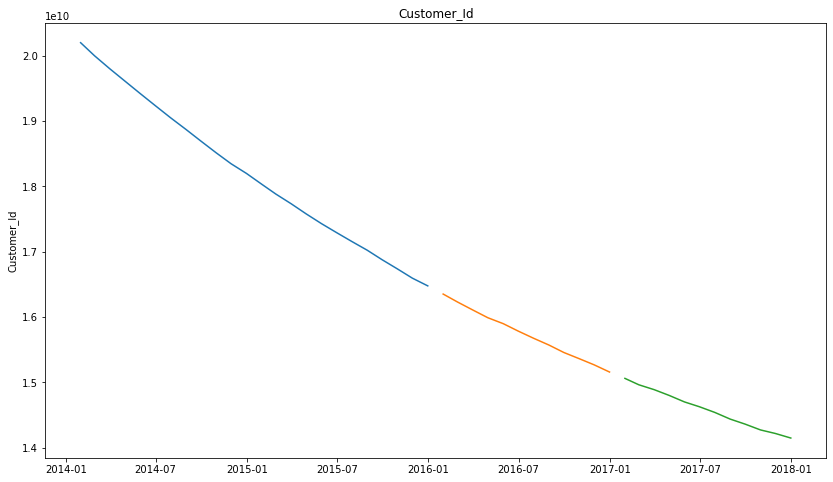

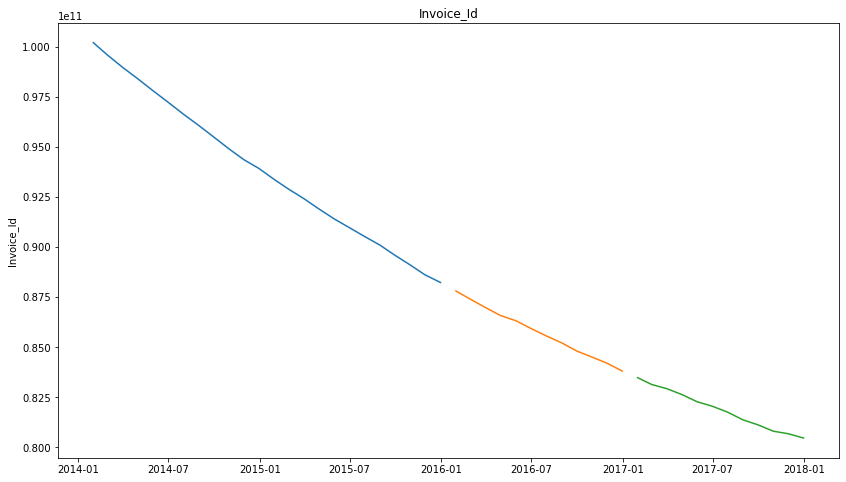

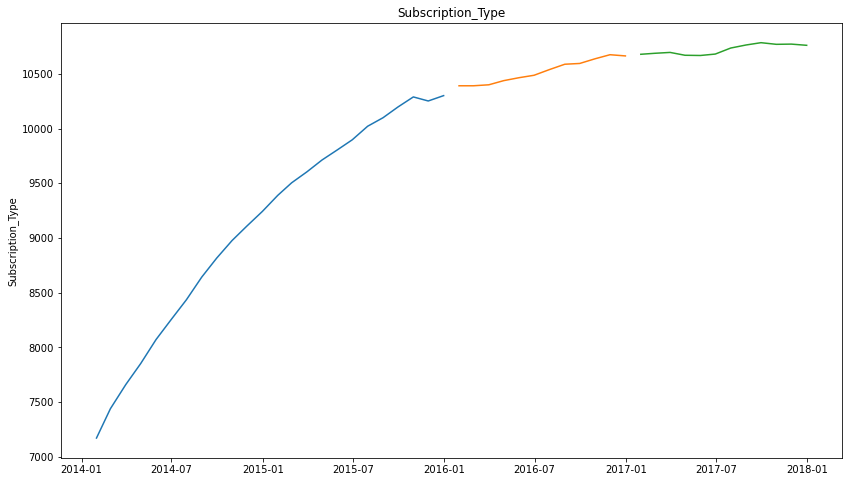

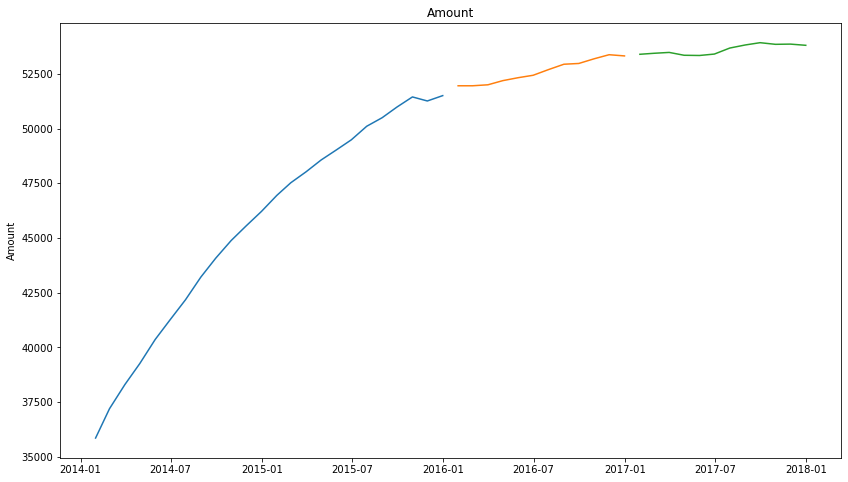

In [22]:
# Take a look at all columns in train
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


#### Helper Functions:

In [23]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [24]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [25]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [26]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Forecasting:

#### Last Observed Value: Assume the future will look like the now

In [27]:
train.head(2)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,20199990000,100199990000,7170.0,35850.0
2014-02-28,20000052061,99592010100,7438.0,37190.0


In [28]:
amount = train['Amount'][-1:][0]
amount

51505.0

In [29]:
subtype = train['Subscription_Type'][-1:][0]
subtype

10301.0

Apply predictions to our observations...

In [30]:
# Create a function to be used in future models  
yhat_df = pd.DataFrame(
    {'Amount': [amount],
     'Subscription_Type': [subtype]},
     index = validate.index)
yhat_df.head()

,Amount,Subscription_Type
Month_Invoiced,,
2016-01-31,51505.0,10301.0
2016-02-29,51505.0,10301.0
2016-03-31,51505.0,10301.0
2016-04-30,51505.0,10301.0
2016-05-31,51505.0,10301.0


#### Plot Actual vs Predicted Values

Amount -- RMSE: 1222


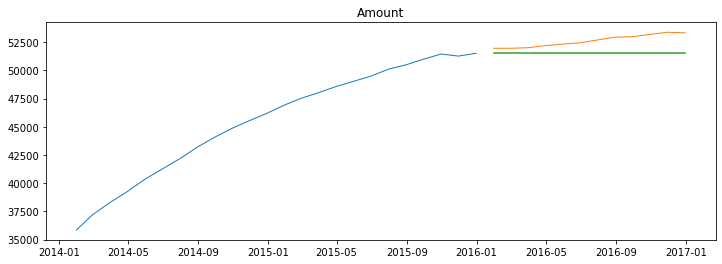

In [31]:
plot_and_eval('Amount')

Subscription_Type -- RMSE: 244


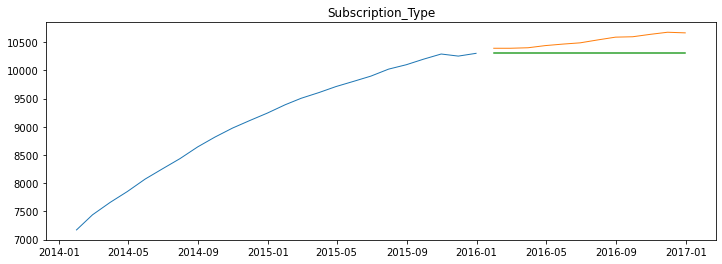

In [32]:
plot_and_eval('Subscription_Type')

#### Evaluate

In [33]:
# Create a dataframe
eval_df = append_eval_df(model_type = 'Last Obversed Value', target_var = 'Amount')
eval_df = append_eval_df(model_type = 'Last Obversed Value', target_var = 'Subscription_Type')

eval_df

,model_type,target_var,rmse
0,Last Obversed Value,Amount,1222.0
1,Last Obversed Value,Subscription_Type,244.0


#### Simple Average: Assume the historical average is predictive of future values

Use average to make predictions...

In [34]:
amount = round(train['Amount'].mean(), 2)
amount

45568.54

In [35]:
subtype = round(train['Subscription_Type'].mean(), 2)
subtype

9113.71

Apply predictions to the observations...

In [36]:
# Create a function to be used in future models  
yhat_df = pd.DataFrame(
    {'Amount': [amount],
     'Subscription_Type': [subtype]},
     index = validate.index)
yhat_df.head(2)

,Amount,Subscription_Type
Month_Invoiced,,
2016-01-31,45568.54,9113.71
2016-02-29,45568.54,9113.71


#### Plot Actual vs Predicted Values

Amount -- RMSE: 7063


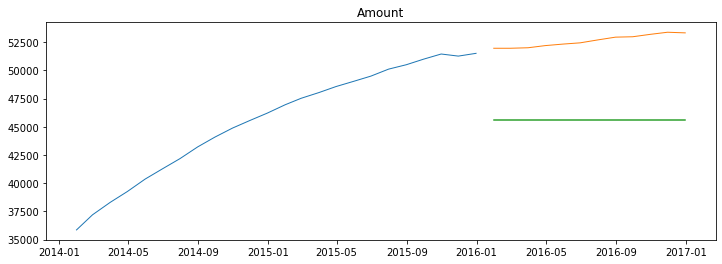

In [37]:
plot_and_eval('Amount')

Subscription_Type -- RMSE: 1413


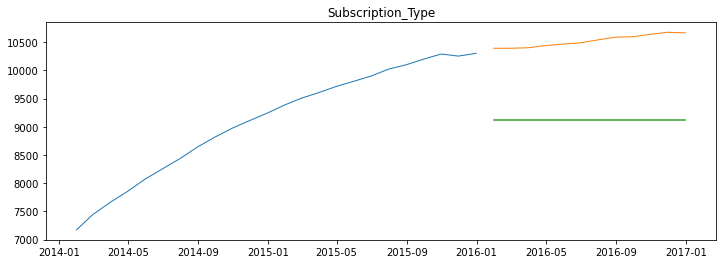

In [38]:
plot_and_eval('Subscription_Type')

In [39]:
eval_df = append_eval_df(model_type = 'Simple Average', target_var = 'Amount')
eval_df = append_eval_df(model_type = 'Simple Average', target_var = 'Subscription_Type')

In [40]:
eval_df

,model_type,target_var,rmse
0,Last Obversed Value,Amount,1222.0
1,Last Obversed Value,Subscription_Type,244.0
2,Simple Average,Amount,7063.0
3,Simple Average,Subscription_Type,1413.0


### 4 Month Rolling Average

In [41]:
period = 4
amount = round(train['Amount'].rolling(period).mean()[-1], 2)
subtype = round(train['Subscription_Type'].rolling(period).mean()[-1], 2)
print(amount, subtype)

51298.75 10259.75


In [42]:
# Create a function to be used in future models  
yhat_df = pd.DataFrame(
    {'Amount': [amount],
     'Subscription_Type': [subtype]},
     index = validate.index)
yhat_df.head(2)

,Amount,Subscription_Type
Month_Invoiced,,
2016-01-31,51298.75,10259.75
2016-02-29,51298.75,10259.75


Amount -- RMSE: 1412


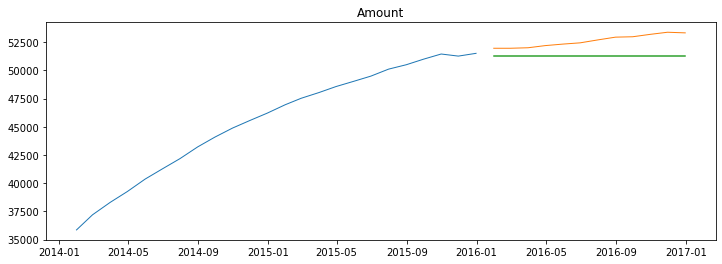

In [43]:
plot_and_eval('Amount')

Subscription_Type -- RMSE: 282


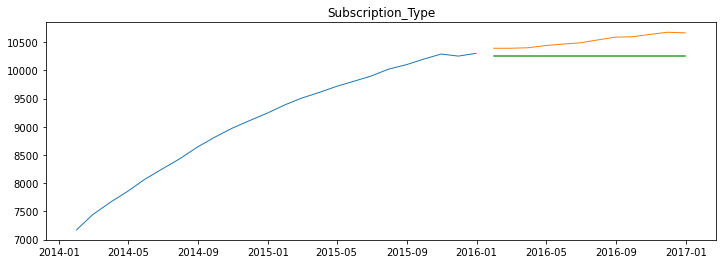

In [44]:
plot_and_eval('Subscription_Type')

In [45]:
eval_df = append_eval_df(model_type = '4 Month Rolling Average', target_var = 'Amount')
eval_df = append_eval_df(model_type = '4 Month Rolling Average', target_var = 'Subscription_Type')
eval_df

,model_type,target_var,rmse
0,Last Obversed Value,Amount,1222.0
1,Last Obversed Value,Subscription_Type,244.0
2,Simple Average,Amount,7063.0
3,Simple Average,Subscription_Type,1413.0
4,4 Month Rolling Average,Amount,1412.0
5,4 Month Rolling Average,Subscription_Type,282.0


#### Holt's Linear Trend: Exponential smoothing applied to both trend and slope

Customer_Id 



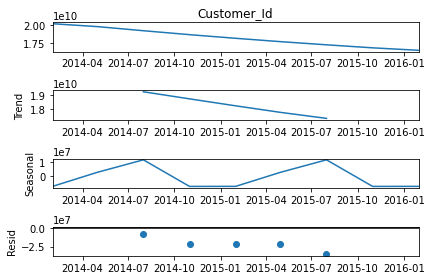

Invoice_Id 



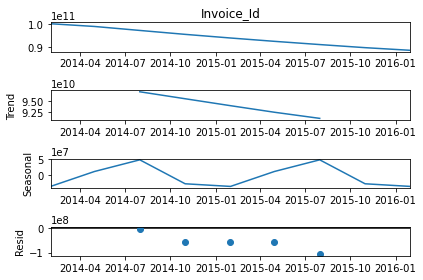

Subscription_Type 



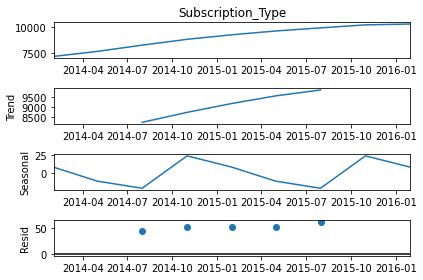

Amount 



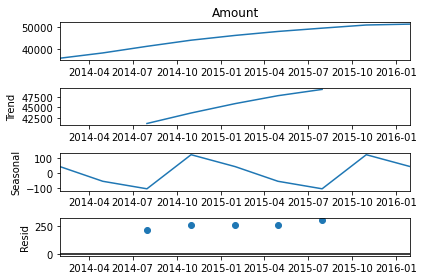

In [46]:
for col in train.columns:   
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

In [47]:
# Loop for doing multiple columns
# cols = 'Amount', 'Subscription_Type'

for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [48]:
yhat_df

,Amount,Subscription_Type,Customer_Id,Invoice_Id
Month_Invoiced,,,,
2016-01-31,51748.56,10359.37,1.633763e+10,8.777165e+10
2016-02-29,51961.89,10413.54,1.619965e+10,8.731667e+10
2016-03-31,52173.19,10464.33,1.606306e+10,8.686624e+10
2016-04-30,52382.47,10511.96,1.592783e+10,8.642032e+10
2016-05-31,52589.76,10556.62,1.579395e+10,8.597886e+10
2016-06-30,52795.08,10598.50,1.566141e+10,8.554181e+10
2016-07-31,52998.44,10637.77,1.553019e+10,8.510913e+10
2016-08-31,53199.86,10674.59,1.540029e+10,8.468078e+10
2016-09-30,53399.37,10709.11,1.527169e+10,8.425671e+10


Customer_Id -- RMSE: 158216866


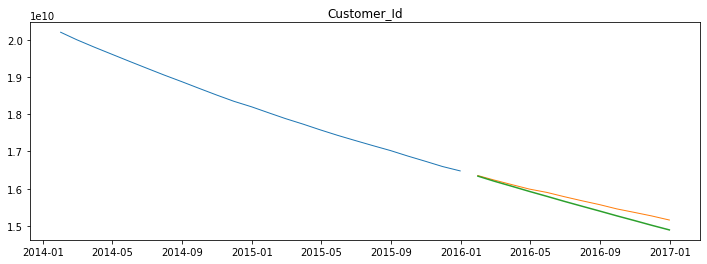

Invoice_Id -- RMSE: 488469629


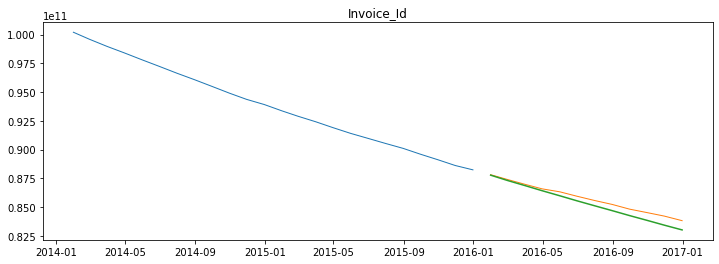

Subscription_Type -- RMSE: 92


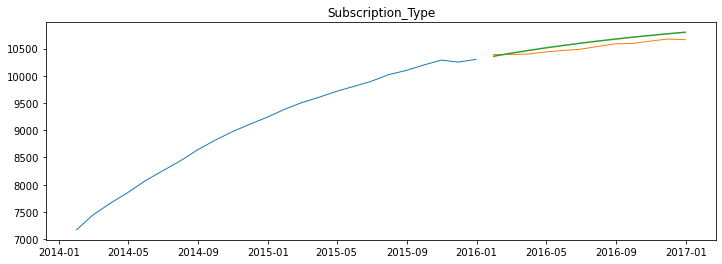

Amount -- RMSE: 346


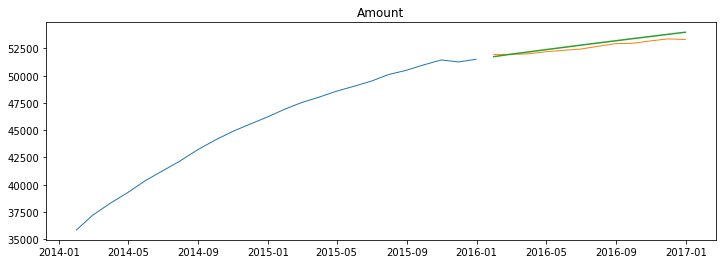

In [49]:
for col in train.columns:
    plot_and_eval(target_var = col)

#### Evaluate

In [50]:
eval_df = append_eval_df(model_type = 'Holt\'s Optimized', target_var = 'Amount')
eval_df = append_eval_df(model_type = 'Holt\'s Optimized', target_var = 'Subscription_Type')
eval_df

,model_type,target_var,rmse
0,Last Obversed Value,Amount,1222.0
1,Last Obversed Value,Subscription_Type,244.0
2,Simple Average,Amount,7063.0
3,Simple Average,Subscription_Type,1413.0
4,4 Month Rolling Average,Amount,1412.0
5,4 Month Rolling Average,Subscription_Type,282.0
6,Holt's Optimized,Amount,346.0
7,Holt's Optimized,Subscription_Type,92.0


####  Predict Based on Previous Cycle

##### Re-split the Data

In [51]:
df2 = df[['Amount', 'Subscription_Type']]

train = df2[:'2015']
validate = df2['2016']
test = df2['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(24, 2)
(12, 2)
(12, 2)


,Amount,Subscription_Type
Month_Invoiced,,
2015-08-31,50495.0,10099.0
2015-09-30,50985.0,10197.0
2015-10-31,51445.0,10289.0
2015-11-30,51260.0,10252.0
2015-12-31,51505.0,10301.0


In [52]:
yhat_df = train['2015'] + train.diff(12).mean()

In [53]:
train.diff(12).mean()

Amount               8088.75
Subscription_Type    1617.75
dtype: float64

In [54]:
train.loc['2015'].head()

,Amount,Subscription_Type
Month_Invoiced,,
2015-01-31,46945.0,9389.0
2015-02-28,47520.0,9504.0
2015-03-31,48025.0,9605.0
2015-04-30,48560.0,9712.0
2015-05-31,49025.0,9805.0


In [55]:
yhat_df.head()

,Amount,Subscription_Type
Month_Invoiced,,
2015-01-31,55033.75,11006.75
2015-02-28,55608.75,11121.75
2015-03-31,56113.75,11222.75
2015-04-30,56648.75,11329.75
2015-05-31,57113.75,11422.75


In [56]:
# Take a look at the 2 together to see how tey 
pd.concat([yhat_df.head(1), validate.head(1)])

,Amount,Subscription_Type
Month_Invoiced,,
2015-01-31,55033.75,11006.75
2016-01-31,51955.00,10391.00


Amount -- RMSE: 5192


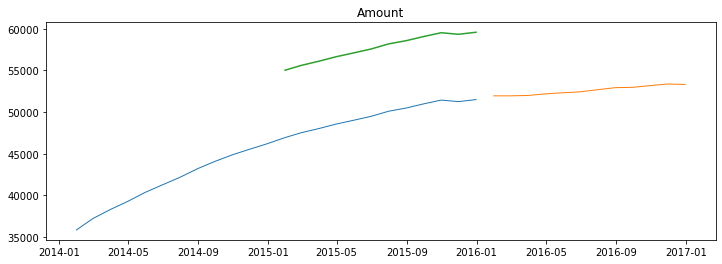

Subscription_Type -- RMSE: 1038


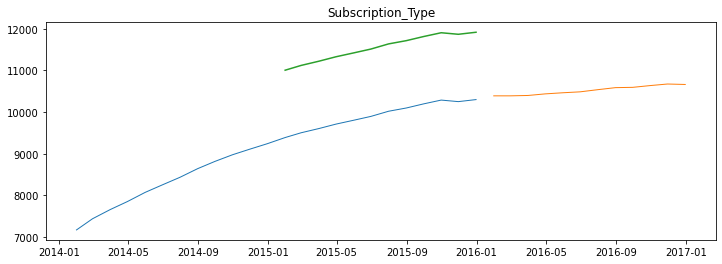

In [59]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [64]:
amount_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

subtype_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == amount_min_rmse) | 
         (eval_df.rmse == subtype_min_rmse))]

,model_type,target_var,rmse
6,Holt's Optimized,Amount,346.0
7,Holt's Optimized,Subscription_Type,92.0


In [ ]:
yhat_df = validate.mean()
yhat_df.index = test.index

In [62]:
eval_df = append_eval_df(model_type = 'Based On Previous Cycle', target_var = 'Amount')
eval_df = append_eval_df(model_type = 'Based On Previous Cycle', target_var = 'Subscription_Type')
eval_df.sort_values(by = 'rmse')

,model_type,target_var,rmse
7,Holt's Optimized,Subscription_Type,92.0
1,Last Obversed Value,Subscription_Type,244.0
5,4 Month Rolling Average,Subscription_Type,282.0
6,Holt's Optimized,Amount,346.0
9,previous_year,Subscription_Type,1038.0
11,Based On Previous Cycle,Subscription_Type,1038.0
13,Based On Previous Cycle,Subscription_Type,1038.0
15,Based On Previous Cycle,Subscription_Type,1038.0
0,Last Obversed Value,Amount,1222.0
4,4 Month Rolling Average,Amount,1412.0
